In [1]:
from PIL import Image, ImageFont, ImageDraw 
import glob
import string
import random
import os
import shutil
import math
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling
from tensorflow.keras import Input 
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt 
import cv2

2.6.0


In [2]:
unmarked_path = "C:/Users/Scrip0/Desktop/Training/Unmarked" # Path to marked images
marked_path = os.path.dirname(unmarked_path) + "/Marked"
unmarked_imgs = []
marked_imgs = []
ext = ["jpg","png", "jpeg"];
for file in (file for file in (glob.glob(unmarked_path + '/*.%s' % e) for e in ext) if file != []):
    for image in file:
        unmarked_imgs.append(image)

In [3]:
def generate_word():
    letters = string.ascii_letters + string.digits + string.punctuation;
    return "".join(random.choice(letters) for i in range(random.randint(5, 20)))

In [4]:
class point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
def generate_points(width, height, angle, side):
    points = []
    num = random.randint(2, 5)
    half_width = int(width / 2)
    gap = int(height / (num - 1)) 
    if (side == "right"): gap = int(gap * 1.5)
    extra = random.randint(0, gap)
    for i in range(0, num):
        points.append(point(half_width, gap * i - extra))
        
    if (side == "right"):
        more = int(((-half_width * math.tan(math.radians(angle))) - extra) / gap)  + 1
    else:
        more = int(((half_width * math.tan(math.radians(angle))) - extra) / gap)  + 1
    for i in range(-more - 1, 0):
        points.insert(0, point(half_width, gap * i - extra))
    for i in range(num, num + more):
        points.append(point(half_width, gap * i - extra))
    return points

def draw_lines_left(image, angle, watermark, line, color, opacity, size):
    points = generate_points(image.size[0], image.size[1], angle, "left")
    half_width = int(image.width / 2)
    tan = math.tan(math.radians(angle))
    for point in points:
        x = 0
        y = int(half_width * tan + point.y)
        while (x < image.width):
            image.paste(watermark, (x, y), watermark)
            line = Image.new('RGBA', image.size, (255,255,255,0))
            draw = ImageDraw.Draw(line)
            line_width = size * 3
            draw.line((x + watermark.width, y, x + watermark.width + line_width, y - line_width * tan), fill=(color[0], color[1], color[2], opacity), width=int(size / 7))
            image.alpha_composite(line)
            x += watermark.width + line_width
            y -= int(line_width * tan) + watermark.height
            
def draw_lines_right(image, angle, watermark, line, color, opacity, size):
    points = generate_points(image.size[0], image.size[1], angle, "right")
    half_width = int(image.width / 2)
    tan = math.tan(math.radians(angle))
    for point in points:
        x = image.width - watermark.width
        y = int(-half_width * tan + point.y)
        while (x > -watermark.width):
            image.paste(watermark, (x, y), watermark)
            line = Image.new('RGBA', image.size, (255,255,255,0))
            draw = ImageDraw.Draw(line)
            line_width = size * 3
            draw.line((x, y, x - line_width, y + line_width * tan), fill=(color[0], color[1], color[2], opacity), width=int(size / 7))
            image.alpha_composite(line)
            x -= watermark.width + line_width
            y -= -int(line_width * tan) + watermark.height

In [5]:
if (os.path.isdir(marked_path)): shutil.rmtree(marked_path, ignore_errors=True)
os.mkdir(marked_path)
for img in unmarked_imgs:
    angle = random.randint(30, 60)
    color = random.randint(0, 256), random.randint(0, 256), random.randint(0, 256)
    opacity = random.randint(40, 250)
    image = Image.open(img)
    image = image.convert('RGBA')
    text = generate_word()
    size = random.randint(10, 30)
    font = ImageFont.truetype("impact.ttf", size)
    
    watermark = Image.new('RGBA', font.getsize(text), (255,255,255,0))
    d = ImageDraw.Draw(watermark)    
    d.text((0, 0), text, fill=(color[0], color[1], color[2], opacity), font=font)
    
    watermark = watermark.rotate(angle, expand = 1)
    draw_lines_left(image, angle, watermark, image, color, opacity, size)
    
    watermark = watermark.rotate(-90, expand = 1)
    draw_lines_right(image, -90 + angle, watermark, image, color, opacity, size)
    path = marked_path + "/" + os.path.splitext(os.path.basename(img))[0] + ".png"
    image.save(path)
    
    marked_imgs.append(path)

In [6]:
width = 256
height = 256
def createPixelArr(files):
    data = []
    for image in files:# take each image and use imread to get the pixel values in a matrix 
            img_arr = cv2.imread(image, cv2.IMREAD_COLOR)
            resized_arr = cv2.resize(img_arr, (width, height)) # rescale the image so every image is of the same dimension
            data.append(resized_arr) # add the matrix of pixel values 
    return np.array(data)

In [7]:
train_marked = createPixelArr(marked_imgs)
train_unmarked = createPixelArr(unmarked_imgs)
unmarked_imgs = []
marked_imgs = []

In [8]:
x_train, x_test, y_train, y_test = train_test_split(train_marked, train_unmarked, train_size=0.8, random_state=1) 
train_marked = []
train_unmarked = []

In [9]:
def scale(data):
    return data / 256
x_train = scale(x_train)
x_test = scale(x_test)
y_train = scale(y_train)
y_test = scale(y_test)

In [10]:
print(x_train.shape)
print(y_train.shape)

(1763, 256, 256, 3)
(1763, 256, 256, 3)


In [159]:
model = keras.Sequential()

model.add(keras.Input(shape=(width, height, 3))) #3 if RGB, 1 if GrayScale

model.add(tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", padding="same"))
model.add(tf.keras.layers.UpSampling2D(2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", padding="same"))
model.add(tf.keras.layers.UpSampling2D(2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(3, 3, activation="sigmoid", padding="same"))

In [160]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_44 (Conv2DT (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_transpose_45 (Conv2DT (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 64, 64, 32)      

In [161]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss="MeanSquaredError")

In [162]:
early_stop = EarlyStopping(patience=5, monitor='loss', restore_best_weights=True)
history = model.fit(x_train, y_train, batch_size=20, epochs=100, callbacks=[early_stop])

Epoch 1/100
89/89 [==============================] - 666s 7s/step - loss: 0.0200
Epoch 2/100
89/89 [==============================] - 640s 7s/step - loss: 0.0105
Epoch 3/100
89/89 [==============================] - 619s 7s/step - loss: 0.0093
Epoch 4/100
89/89 [==============================] - 606s 7s/step - loss: 0.0090
Epoch 5/100
89/89 [==============================] - 600s 7s/step - loss: 0.0080
Epoch 6/100
89/89 [==============================] - 752s 8s/step - loss: 0.0081
Epoch 7/100
89/89 [==============================] - 614s 7s/step - loss: 0.0075
Epoch 8/100
89/89 [==============================] - 618s 7s/step - loss: 0.0073
Epoch 9/100
89/89 [==============================] - 605s 7s/step - loss: 0.0071
Epoch 10/100
89/89 [==============================] - 615s 7s/step - loss: 0.0070
Epoch 11/100
89/89 [==============================] - 592s 7s/step - loss: 0.0068
Epoch 12/100
89/89 [==============================] - 594s 7s/step - loss: 0.0065
Epoch 13/100
89/89 [=====

In [163]:
model.save('Watermark.h5')

In [164]:
# model = keras.models.load_model('Watermark.h5') # If you want to load saved model

In [165]:
result = model.predict(x_test)
model.evaluate(result, y_test)

14/14 [==============================] - 34s 2s/step - loss: 0.0079


0.007876680232584476

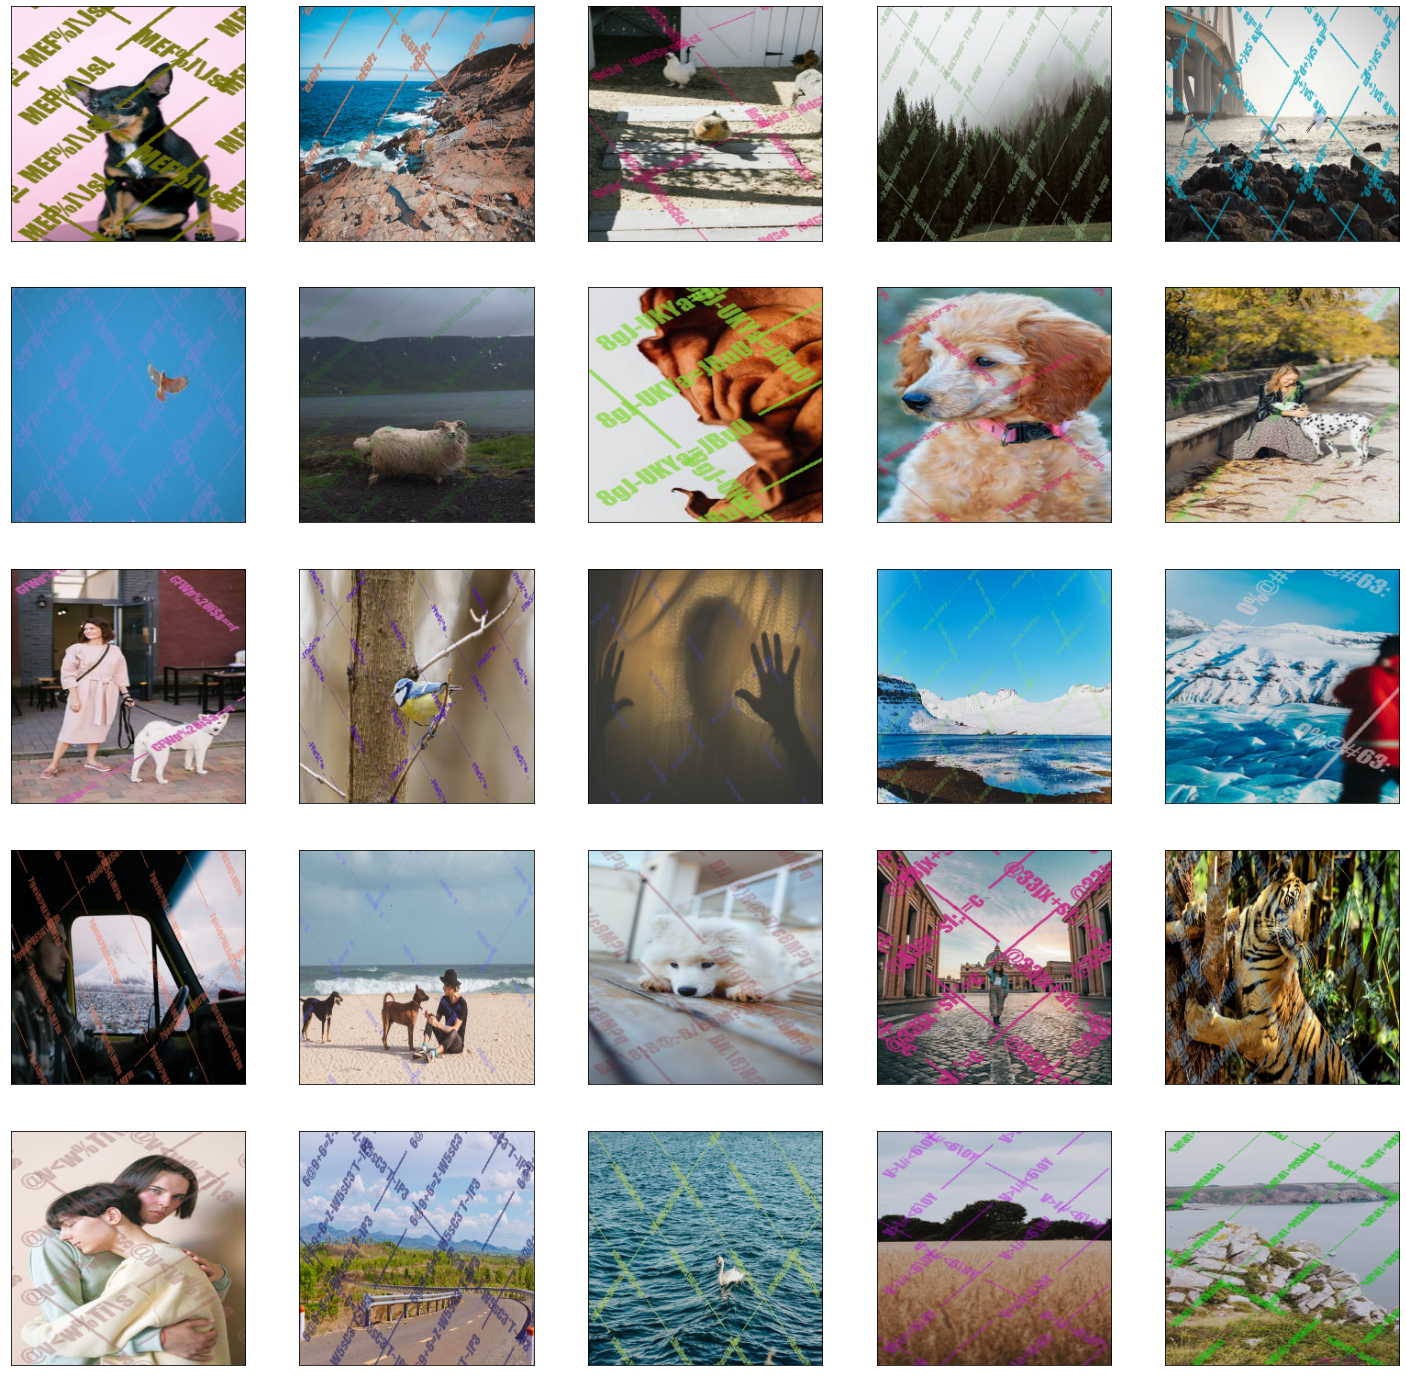

In [166]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(x_test[i].astype('float32'), cv2.COLOR_BGR2RGB))
plt.show()

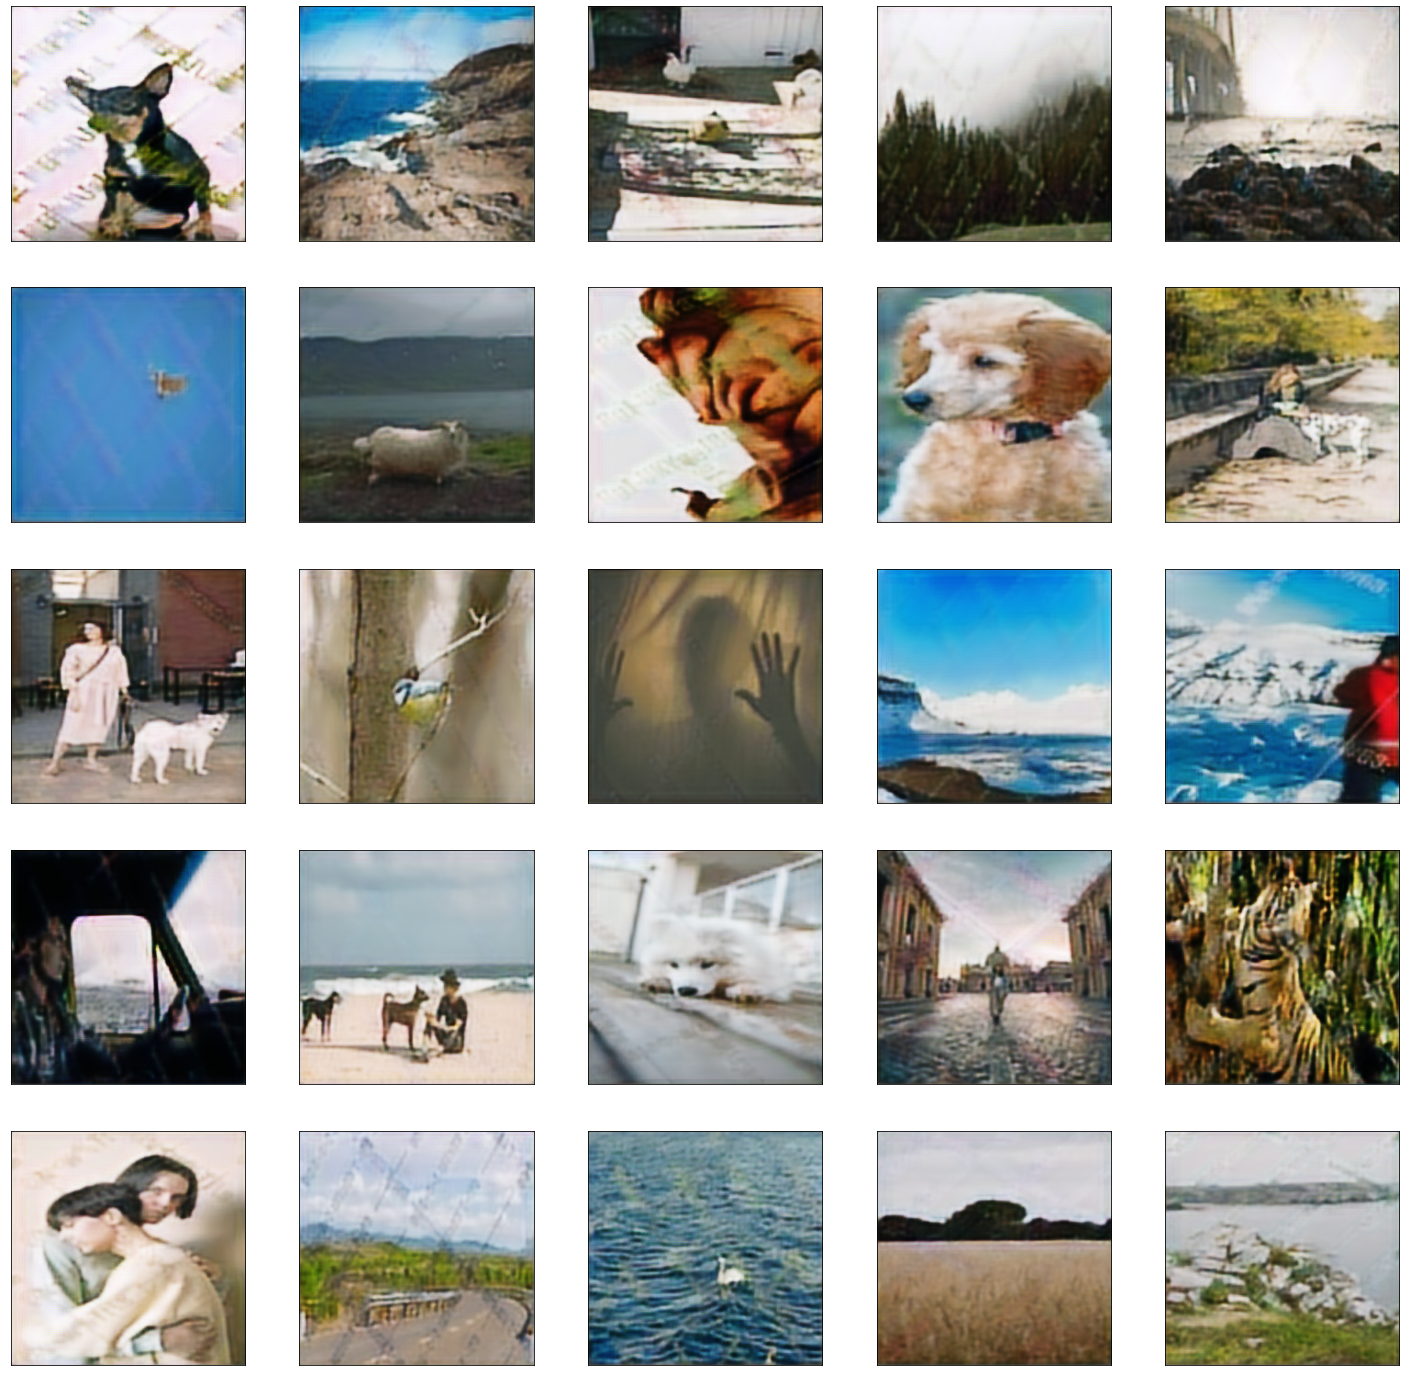

In [167]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(result[i].astype('float32'), cv2.COLOR_BGR2RGB))
plt.show()

(350, 467, 3)


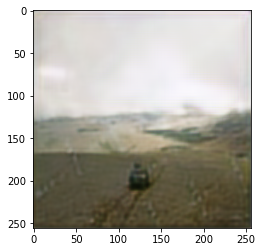

In [230]:
img_arr = cv2.imread("C:/Users/Scrip0/Desktop/Training/Marked/pexels-photo-4326000.png", cv2.IMREAD_COLOR)
print(img_arr.shape)
img_arr = cv2.resize(img_arr, (width, height))
img_arr = img_arr.reshape(1, width, height, 3) 
img_arr = img_arr / 256
result = model.predict(img_arr)
plt.imshow(cv2.cvtColor(result[0].astype('float32'), cv2.COLOR_BGR2RGB))

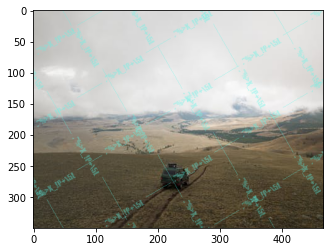

In [231]:
def normalize(img):
    img = img.reshape(1, width, height, 3) 
    img = img / 256
    return img

def get_result(img):
    num_y = int(img.shape[0] / height)
    num_x = int(img.shape[1] / width)
    result = []
    for i in range(num_y):
        row = []
        for j in range(num_x):
            prediction = model.predict(normalize(img[i * height:(i + 1) * height, j * width:(j + 1) * width])).reshape(width, height, 3)
            if (len(row) == 0):
                row = prediction
            else:
                row = np.concatenate((row, prediction), axis=1)
        prediction = model.predict(normalize(img[i * height:(i + 1) * height, img.shape[1] - width:img.shape[1]])).reshape(width, height, 3)
        prediction = prediction[0:height, width - (img.shape[1] - width * num_x):width]
        if (len(row) == 0):
            row = prediction
        else:
            row = np.concatenate((row, prediction), axis=1)
        if (len(result) == 0):
            result = row 
        else: 
            result = np.concatenate((result, row), axis=0)
            
    row = []
    for j in range(num_x):
        prediction = model.predict(normalize(img[img.shape[0] - height:img.shape[0], j * width:(j + 1) * width])).reshape(width, height, 3)
        prediction = prediction[height - (img.shape[0] - height * num_y):height, 0:width]
        if (len(row) == 0):
            row = prediction
        else:
            row = np.concatenate((row, prediction), axis=1)
    prediction = model.predict(normalize(img[img.shape[0] - height:img.shape[0], img.shape[1] - width:img.shape[1]])).reshape(width, height, 3)
    prediction = prediction[height - (img.shape[0] - height * num_y):height, width - (img.shape[1] - width * num_x):width]
    if (len(row) == 0):
        row = prediction
    else:
        row = np.concatenate((row, prediction), axis=1)
    if (len(result) == 0):
        result = row 
    else: 
        result = np.concatenate((result, row), axis=0)
        
    return result
    
img_arr = cv2.imread("C:/Users/Scrip0/Desktop/Training/Marked/pexels-photo-4326000.png", cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))

(350, 467, 3)


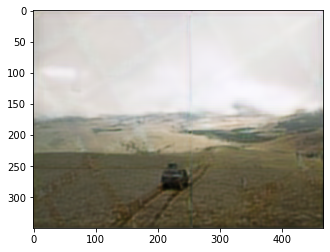

In [232]:
result = get_result(img_arr)
print(result.shape)
plt.imshow(cv2.cvtColor(result.astype('float32'), cv2.COLOR_BGR2RGB))